  <style>
    .container {
      display: flex;
      gap: 10px; /* Optional spacing between divs */
    }

    .box h1 {
      font-size: 50px;
      padding-top: 10px;
      font-weight: 600;
    }
  </style>
  <div class="container" style="">
    <div class="box">
      <h1>Planning for Robotics</h1>
    </div>
    <div class="box" align="right">
      <img src="images/template/course_logo.svg" alt="Planning for Robotics" height="70"/>
      &nbsp;&nbsp;&nbsp;&nbsp;
      <img src="images/template/logo_i6.svg" alt="Chair Logo" height="70"/>
      &nbsp;&nbsp;&nbsp;&nbsp;
    </div>
  </div>


# Exercise Sheet 2 - Probabilistic Motion Planning

## Introduction

### Learning Objectives
- Understand Probabilistic/Monte-Carlo Methods
- Truly Understand Samplin-based Motion Planning
- Create your own implementations of RRT


### Acknowledgments
This exercise is largely inspired by Beomjoon Kim's AI614 (Robot Task and Motion Planning) at KAIST as well as the Chapters 4 and 5 of Steven LaValle's book. Further note should be given to Prof. Kevin Buchin's online lecture on Motion Planning (https://www.youtube.com/watch?v=p8AzzvwV5M4) and the book Modern Robotics by Lynch and Park. The Star Algorithm pseudocode is taken from https://cp-algorithms.com/geometry/minkowski.html.

### Env Setup

In [31]:
from random import *
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
import math
from matplotlib.animation import FFMpegWriter, FuncAnimation
import time
import pandas as pd
import numpy as np

## Task 0: Environment Creation
In the following tasks you will need to create a motion planning domain in 2D. This means that you want to have some environment, in which you can express things like obstacles, paths, and sampled points.
You also want to be able to visualise multiple steps of expansion (e.g., in search). An example of how this can be done with matplotlib is given here. 

### Coding Task 0.1 - Create an Environment
Create your own 2D environment and visualisation function here (or adapt the given one), so you can use it for the next tasks. I do recommend to look into the next tasks for reference.

In [32]:
class Robot:
    def __init__(self, edges, theta=None, color='blue'):
        # Initialize orientation
        if theta is None:
            theta = random() * 2 * math.pi
        self.edges = edges
        # Compute initial center
        self.x = (edges[0][0] + edges[1][0]) / 2
        self.y = (edges[0][1] + edges[1][1]) / 2
        self.theta = theta
        self.color = color
        self.radius = None
        self.calculate_radius()

    def calculate_radius(self):
        """
        Radius from center to first edge corner.
        """
        dx = self.x - self.edges[0][0]
        dy = self.y - self.edges[0][1]
        self.radius = math.hypot(dx, dy)

    def move_toward(self, goal, step_size, goal_radius):
        """
        Move this robot toward `goal` by at most `step_size`.
        Stops at goal boundary (goal_radius + self.radius).
        """
        dx = goal[0] - self.x
        dy = goal[1] - self.y
        dist = math.hypot(dx, dy)
        target_dist = goal_radius + self.radius
        if dist > target_dist:
            # unit direction vector
            ux, uy = dx / dist, dy / dist
            move = min(step_size, dist - target_dist)
            self.x += ux * move
            self.y += uy * move
            self.theta = math.atan2(dy, dx)
            self.calculate_edges()

    def calculate_edges(self):
        """
        Rebuild a square (4 edges) around (self.x, self.y) with half-side = radius / sqrt(2).
        Rotated by self.theta.
        """
        half = self.radius / math.sqrt(2)
        # Local corners
        local = [(-half, -half), (half, -half), (half, half), (-half, half)]
        c, s = math.cos(self.theta), math.sin(self.theta)
        self.edges = []
        for lx, ly in local:
            wx = self.x + lx * c - ly * s
            wy = self.y + lx * s + ly * c
            self.edges.append((wx, wy))

    def get_position(self):
        return self.x, self.y

    def get_size(self):
        return self.radius

    def get_color(self):
        return self.color

    def set_position(self, x, y):
        self.x, self.y = x, y
        self.calculate_edges()

In [33]:
class Environment:
    def __init__(self, x_range, y_range, obstacles=None,
                 start=None, goal=None, goal_radius=5):
        self.x_range = x_range
        self.y_range = y_range
        self.obstacles = obstacles or []
        self.start = start
        self.goal = goal
        self.goal_radius = goal_radius
        self.robot = None

    def add_robot(self, robot):
        """Add a Robot instance to the environment."""
        self.robot = robot

    def plot(self, show=True):
        fig, ax = plt.subplots()
        ax.set_xlim(self.x_range)
        ax.set_ylim(self.y_range)
        ax.set_aspect('equal')
        # Plot goal and start
        if self.goal:
            ax.add_patch(Circle(self.goal, self.goal_radius,
                                color='green', alpha=0.3))
        if self.start:
            ax.add_patch(Circle(self.start, self.goal_radius,
                                color='blue', alpha=0.3))
        # Plot obstacles
        for obs in self.obstacles:
            ax.add_patch(Polygon(obs, closed=True,
                                 color='red', alpha=0.5))
        # Plot robot
        if self.robot:
            ax.add_patch(Polygon(self.robot.edges, closed=True,
                                 color=self.robot.color, alpha=0.6))
        if show:
            plt.show()

    def move_robot(self, step_size=10.0):
        """Move robot toward the goal by `step_size`."""
        self.robot.move_toward(self.goal, step_size, self.goal_radius)

    def animate(self, step_size=5.0, frames=100, interval=100):
        """
        Live animation of the robot moving toward the goal.

        Parameters:
        - step_size: how far the robot moves each frame
        - frames: number of animation frames
        - interval: time between frames in ms

        Returns:
          The FuncAnimation object.
        """
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(self.x_range)
        ax.set_ylim(self.y_range)
        ax.set_aspect('equal')
        # Static elements
        if self.goal:
            ax.add_patch(Circle(self.goal, self.goal_radius,
                                color='green', alpha=0.3))
        if self.start:
            ax.add_patch(Circle(self.start, self.goal_radius,
                                color='blue', alpha=0.3))
        for obs in self.obstacles:
            ax.add_patch(Polygon(obs, closed=True,
                                 color='red', alpha=0.5))

        # Robot patch
        robot_patch = Polygon(self.robot.edges, closed=True,
                              color=self.robot.color, alpha=0.6)
        ax.add_patch(robot_patch)

        def init():
            robot_patch.set_xy(self.robot.edges)
            return (robot_patch,)

        def update(frame):
            self.move_robot(step_size)
            robot_patch.set_xy(self.robot.edges)
            return (robot_patch,)

        anim = FuncAnimation(
            fig, update, init_func=init,
            frames=frames,
            interval=interval,
            blit=False
        )
        # For Jupyter notebooks: embed animation inline
        try:
            from IPython.display import HTML, display
            display(HTML(anim.to_jshtml()))
        except Exception:
            # Fall back to interactive window
            plt.show()
        return anim


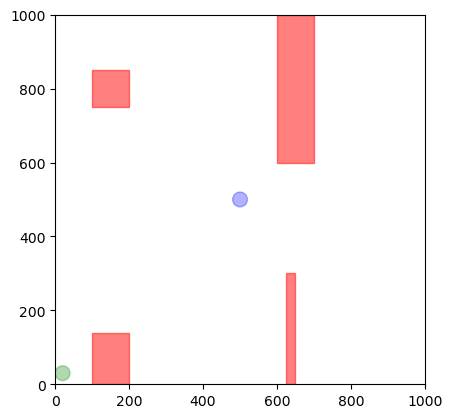

In [34]:
# Example Configurations
map = [[0,1000], [0,1000]]
target = (20, 30)
init = (500,500)
obstacles = [[(100,0), (200,0), (200,140), (100,140)],[(600,1000), (600,600), (700, 600), (700, 1000)],[(650,0),(650, 300),(625,300),(625,0)],[(100,850),(100, 750),(200,750),(200,850)]]
target_radius = 20

# TODO: Implement your own visualisation function for the environment, show multiple steps of a changing environment (e.g., a moving robot) as a gif
env = Environment(
    x_range=map[0],
    y_range=map[1],
    obstacles=obstacles,
    start=init,
    goal=target,
    goal_radius=target_radius
)
env.plot()

## Task 1: Configuration Spaces and 2D Rigid Bodies
As discussed in the introductory lecture, we can solve almost all of the problems that we are looking into for this lab course through search. To properly perform search, we do need to find a suitable representation of our state space. For motion planning problems, the idea of planning in configuration space $C$ established itself as the go-to representation. In the following task, we will explore some of the core ideas of configuration space representations. 

### Configuration Space
In the $C$-space, all possible transformations applicable to a robot are represented in one continuous space. This is different from the idea of the workspace, which is the physical environment the robot exists in. 

Take, for example, a point or circle robot in a 2 dimensional workspace, for this very simple example we can omit rotation, and thus we get that the configuration is just $(x,y) \in \mathbb{R}^2$. However, in many cases the dimensions of $C$ and the workspace do not match. 

For a simple free-moving rigid body in $2D$, we must also consider the body's rotation, usually denoted as theta. Our configuration is now $(x,y,\theta) \in \mathbb{R}^2 \times \mathbb{S}^1$. Here, $\mathbb{S}^1$ denotes the $n$-Sphere for $n=1$. Why do we model our rotation like this? Because the robot can freely revolve, meaning that it "jumps" from 359 degrees to 0 degrees, meaning that the resulting configuration space is actually a torus. 

This notion of topology becomes important later when we perform search in the configuration space and need to define a distance measure. However, thankfully many robots do not have revolute joints without limits, thus in practice our geometry is a lot more simple. 

To get a better understanding of topology of $C$ vs the workspace, I encourage you to explore this simple demo: https://archive.lajones21.com/configurationspace.html

### Coding Task 1.1 - Configuration Space Visualisation
In this task we will look into the configuration space of a polygonal robot in a 2D plane. First you will create two visualisations: one of the robot moving through the plane (you can use last exercise's code to get you started here), then one of how it moves within it's configuration space. For now you don't need to consider that the configuration space is a thorus, instead just model it as $(x,y, \theta) \in \mathbb{R}^2 \times [0, 2\pi)$.

In [35]:
# Example Robot
robot = [(450, 450), (550, 450), (550, 550), (450, 550)]
my_robot = Robot(edges=robot, color='blue')
env = Environment(
    x_range=map[0],
    y_range=map[1],
    obstacles=obstacles,
    goal=target,
    goal_radius=target_radius
)
env.add_robot(my_robot)
%matplotlib notebook
anim = env.animate(step_size=5.0, frames=200, interval=50)

<IPython.core.display.Javascript object>

### Obstacles
As we have just learned, our workspace and our configuration space usually do not match. Obstacles (like walls, boxes, other robots, etc.) occupy the workspace and not the configuration space. To be able to plan collision-free motion, we need to find a way of modelling the geometry of our obstacles in the configuration space. We denote $C_\text{obs}$ the obstacle region of our configuration space and define it as:

$$
C_\text{obs} = \{ q \in C | A(q) \cap O \not = \emptyset\}
$$

where $A(q)$ is the robot's shape in the workspace, according to configuration $q$ (similarly to what we introduced in Exercise 1, 4.1), and $O$ is the obstacles in our workspace. Similarly, we define $C_\text{free} = C \setminus C_\text{obs}$ as the free region, this is the subspace of $C$ in which we find the valid, collision free configurations. 

Note that the free space does not necessarily need to be connected. In many cases, our obstacles divide our free space into several connected components between which the robot can not simple move freely. 

It is easy to see that, if our configuration space and our workspace match, and we have a point robot, this is very easy to compute. Unfortunately these assumptions do not hold in realistic cases, thus we need to find a way to compute the obstacle regions in $C$. We will discuss two methods of computing the obstacle region in the following tasks. 

### Coding Task 1.2 - Explicitely Modelling $C_\text{obs}$
One way of dealing with obstacles is to model them explicitely using so called Minkowski difference. This approach is suitable when $C=\mathbb{R}^n$ for $n=1,2,3$ and a rigid-body robot, limited to translation only. Intuitively, the Minkowski difference expands $C_\text{obs}$ by the space required to allow for collision-free movement. We define the Minkowski difference for any two sets $X, Y \subseteq \mathbb{R}^n$ as:
$$
X \ominus Y = \{ x - y \in \mathbb{R}^n | x \in X, y |in Y \}
$$
for vector substraction $x-y$ defined on $\mathbb{R}^n$. 

While the approach does not generalise nicely, it is very effective under the above constraints with polygonal robots and convex obstacles. Given our obstacle defined as $O$ and our robot $A$, we can obtain the obstacle space by computing $C_\text{obs} = O \ominus A(0)$. We can compute this efficiently for convex robots and convex obstacles in $\mathbb{R}^2$ using the so called star algorithm: 

**Star Algorithm**
Let $X,Y$ be convex polygons. Create lists of the vertices of $X$ and $Y$, and order them according to their polar angles. Now we iterate through both lists at the same time. Let $x_i$ be the $i$-th vertex in $X$ according to our ordering, and $y_j$ in $Y$. 
Set $i=0, j=0$. Now iterate over the indices to create a new polygon $Z$ according to the following procedure:
- Append $x_i+y_j$ to $Z$
- Compare the polar angles of the vector $\overrightarrow{x_i x_{i+1}}$ and $\overrightarrow{y_i y_{i+1}}$
- If the polar angle of $\overrightarrow{x_i x_{i+1}}$ is smaller than $\overrightarrow{y_j y_{j+1}}$, increment $i$, otherwise increment $j$. If both are equal increment both. 
- Continue while $i < |X|$ or $j < |Y|$. 

In this task you should:
- create and visualise a workspace in $\mathbb{R}^2$ with some convex(!) obstacles and a convex(!) robot (again, feel free to use any of the previous exercise's solutions)
- use the minkowski difference to compute the obstacle regions, and visualise them

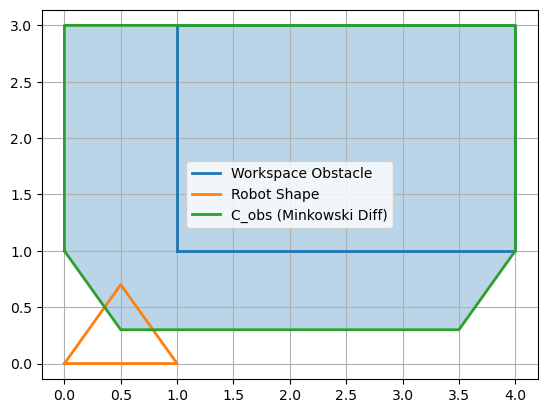

In [36]:
%matplotlib inline
# 1) Sort vertices CCW around their centroid
def sort_vertices_ccw(poly):
    cx = sum(x for x,y in poly) / len(poly)
    cy = sum(y for x,y in poly) / len(poly)
    return sorted(poly, key=lambda p: math.atan2(p[1] - cy, p[0] - cx))

# 2) Get edge vectors of a CCW polygon
def edge_vectors(poly):
    ev = []
    for i in range(len(poly)):
        x1,y1 = poly[i]
        x2,y2 = poly[(i+1) % len(poly)]
        ev.append((x2 - x1, y2 - y1))
    return ev

# 3) Minkowski sum of two convex CCW polygons via the star (merge‐walk) algorithm
def minkowski_sum(X, Y):
    X_ccw = sort_vertices_ccw(X)
    Y_ccw = sort_vertices_ccw(Y)
    ex = edge_vectors(X_ccw)
    ey = edge_vectors(Y_ccw)

    i = j = 0
    n, m = len(ex), len(ey)
    # start at X[0] + Y[0]
    curr = (X_ccw[0][0] + Y_ccw[0][0],
            X_ccw[0][1] + Y_ccw[0][1])
    result = [curr]

    while i < n and j < m:
        # cross‐product to compare polar angles
        cross = ex[i][0]*ey[j][1] - ex[i][1]*ey[j][0]
        if cross > 0:
            # X edge is “next”
            dx, dy = ex[i]
            i += 1
        elif cross < 0:
            # Y edge is “next”
            dx, dy = ey[j]
            j += 1
        else:
            # same angle → take both
            dx = ex[i][0] + ey[j][0]
            dy = ex[i][1] + ey[j][1]
            i += 1; j += 1
        curr = (curr[0] + dx, curr[1] + dy)
        result.append(curr)

    # drain any leftover edges
    while i < n:
        dx, dy = ex[i]
        curr = (curr[0] + dx, curr[1] + dy)
        result.append(curr)
        i += 1
    while j < m:
        dx, dy = ey[j]
        curr = (curr[0] + dx, curr[1] + dy)
        result.append(curr)
        j += 1

    return result

# 4) Minkowski difference = X ⊖ Y = X ⊕ (−Y)
def minkowski_difference(obstacle, robot):
    # reflect robot through origin
    neg_robot = [(-x, -y) for x,y in robot]
    return minkowski_sum(obstacle, neg_robot)

# 5) Simple plotting helper
def plot_polygons(polys, labels=None):
    plt.figure()
    for idx, poly in enumerate(polys):
        # close the loop
        xs = [p[0] for p in poly] + [poly[0][0]]
        ys = [p[1] for p in poly] + [poly[0][1]]

        # fill only the C_obs polygon (here idx == 2)
        if idx == 2:
            plt.fill(xs, ys, alpha=0.3)

        # then draw the outline
        plt.plot(xs, ys, linewidth=2,
                 label=(labels[idx] if labels else None))

    plt.axis('equal')
    plt.grid(True)
    if labels:
        plt.legend()
    plt.show()

# Example usage
def main():
    # Define a convex obstacle and convex robot
    obstacle = [(1, 1), (4, 1), (4, 3), (1, 3)]
    robot = [(0, 0), (1, 0), (0.5, 0.7)]

    # Compute expanded obstacle in configuration space
    c_obs = minkowski_difference(obstacle, robot)
    c_obs_ccw = sort_vertices_ccw(c_obs)

    # Visualize workspace & configuration-space obstacle
    plot_polygons(
        [obstacle, robot, c_obs_ccw],
        labels=["Workspace Obstacle", "Robot Shape", "C_obs (Minkowski Diff)"]
    )

if __name__ == "__main__":
    main()

While Minkowski sums are rather straightforward to compute, no simple solution exists to also cover rotations in the general case. One extension of this approach to also cover rotations is to discretise the rotational dimension. Take for example the rotation in degrees, which means you end up with 360 "slices". You can then compute the Minkowski sums for each of the rotation slices, as if there was no rotation involved.

### Collision Detection
Once we know which configurations $c_i$ to sample from $C$, we need to start figuring out how the collision detection mechanism will work, that allows us to figure out whether $c_i \in C_\text{obs}$. Designing the an efficient *general* collision detection mechanism is difficult, but we will still discuss some core ideas briefly here. In the most simple case, we have convex 2D polygonal obstacles, in that case we can travel along the edges $(x_i, y_i),(x_{i+1}, y_{i+1})$ of the polygon (in one direction) and compute the following:
$$
(y - y_i) (x_{i+1} - x_i) - (x - x_i) (y_{i+1} - y_i)
$$
for $c_i = (x,y)$. If this value is larger than 0, $c_i$ is to the left of the line segment, if it is smaller than 0, then it is to the right. So, if you fore example travel CCW around the edges, and your point is always to the left, then it is inside the polygon. For general polygonal obstacles, we can use a simple ray casting technique: use a ray (or vector) originating from $c_i$, pointing in any direction and count the intersections with the edges of the polygon. If the number of intersections is uneven, then $c_i$ is in the polygon. 

For more complex shapes, we can try to combine some of these methods. E.g., first compute convex hulls of all obstacles, and use the first algorithm. This allows us to reduce the number of more sophisticated (and thus compute-intense) checks to perform. 

### Coding Task 1.3 - Sampling and Checking $C_\text{obs}$
We have seen that Minkowski sums are an efficient way to compute an explicit representation of the obstacle regions in a constrained set of instances. Fortunately, not all types of motion planning algorithms need $C_\text{obs}$ to be explicitely modelled. One such class of motion planning algorithms is sampling-based motion planning, which we'll explore in detail in the next task. 

Virtually all sampling-based motion planners rely on a black-box module that takes care of the collision detection. Whenever the planner considers a new configuration of the robot, it calls this module. The module then determines whether the configuration is a valid one, or whether it is in collision with any of the obstacles in the workspace. 

This separation of responsibilites allows the motion planning algorithm itself to be independent of the configuration space geometry. At the same time, the most suitable way of checking for such collisions, given the type topology of $C$ can be used to perform such checks. 

Your task is to create such a collision check method yourself. You can reuse your definitions for a convex robot and convex obstacles from above. Show how your collision check works by testing multiple configurations of the robot for collisions. 

### MY CODE & COMMENTS

In sampling-based planners (PRM, RRT, etc.), whenever you draw a random configuration 
𝑐_𝑖 ∈ 𝐶_i you need a black-box collision detector that tells you:

Valid ( c_i in C_free): the robot place in configuration ci doesn't intersect with any obstacle
​
  does not intersect any obstacle.

Invalid (c_i in C_obs): would collide with at least one obstacle.

Job is to write that collision-checking module.

In [59]:
def polygons_intersect(poly1, poly2):
    """
    Check if two convex polygons intersect using the Separating Axis Theorem.
    Polygons are given as lists of (x, y) vertices in any order.
    """
    for polygon in (poly1, poly2):
        for i in range(len(polygon)):
            # get the edge
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i + 1) % len(polygon)]
            # compute the perpendicular axis
            axis = (-(y2 - y1), x2 - x1)

            # project both polygons onto the axis
            proj1 = [axis[0] * x + axis[1] * y for x, y in poly1]
            proj2 = [axis[0] * x + axis[1] * y for x, y in poly2]

            # check for gap
            if max(proj1) < min(proj2) or max(proj2) < min(proj1):
                return False  # Found a separating axis
    return True  # No separating axis found


def is_collision(robot, obstacles, config):
    """
    Check if the robot at a given translation collides with any obstacle.
    - robot: list of (x, y) vertices (convex polygon at origin)
    - obstacles: list of convex polygons (each a list of (x, y) vertices)
    - config: (dx, dy) translation to apply to the robot
    """
    # translate robot vertices
    trans_robot = [(x + config[0], y + config[1]) for x, y in robot]
    # check against each obstacle
    for obs in obstacles:
        if polygons_intersect(trans_robot, obs):
            return True
    return False

In [60]:
# Define shapes and test configs
obstacle = [(1, 1), (4, 1), (4, 3), (1, 3)]
robot = [(0, 0), (1, 0), (0.5, 0.7)]
obstacles = [obstacle]
configs = [(0,0), (1,1), (2,2), (3,0), (5,5), (0.5,2.5)]

results = []
for dx, dy in configs:
    results.append({'x': dx, 'y': dy, 'collision': is_collision(robot, obstacles, (dx, dy))})

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

|   x |   y | collision   |
|----:|----:|:------------|
| 0   | 0   | False       |
| 1   | 1   | True        |
| 2   | 2   | True        |
| 3   | 0   | False       |
| 5   | 5   | False       |
| 0.5 | 2.5 | True        |



### Distance in $C$-Space
Determining the distance between two points in our configuration space is important when trying to find a reasonably optimal path in our configuration space. If we just consider translation in 2D or 3D, this doesn't seem difficult to determine. We can just take the Euclidian distance. Similarly, if we have just a set of rotational joints, we are just comparing angles. But as you've probably noticed from our prior examples with rotation and translation in the 2D plane (or rather $SE(2)$), we are actually looking at a mix of rotation and translation. How can we compare angles with euclidian distances? Unfortunately there is no "right" answer for measuring the distance between two points in $SE(2)$, but we can explore some options.

### Coding Task 1.4 - Distance Metrics for $SE(2)$ 
In this task, you should come up with two to three different distance measures (e.g., euclidian+polar angle, geodesic distance, etc.) and explore their impact on the resulting distance value. 

In [50]:
# Distance metrics for SE(2)
def euclidean(p1, p2):
    dx, dy = p1[0] - p2[0], p1[1] - p2[1]
    return np.hypot(dx, dy)

def angular_distance(theta1, theta2):
    d = abs(theta1 - theta2) % (2 * np.pi)
    return min(d, 2 * np.pi - d)

def euclid_plus_angle(p1, p2, w=1.0):
    return euclidean(p1, p2) + w * angular_distance(p1[2], p2[2])

def se2_l2(p1, p2, w=1.0):
    dx, dy = p1[0] - p2[0], p1[1] - p2[1]
    dtheta = angular_distance(p1[2], p2[2])
    return np.sqrt(dx**2 + dy**2 + (w * dtheta)**2)

def geodesic(p1, p2):
    """Approximate SE(2) geodesic using L2-norm on (dx, dy, dtheta)."""
    dx, dy = p1[0] - p2[0], p1[1] - p2[1]
    dtheta = angular_distance(p1[2], p2[2])
    return np.linalg.norm([dx, dy, dtheta])

In [51]:
# Sample configuration pairs: [x, y, theta]
pairs = [
    ([0, 0, 0],        [1, 1, 0]),
    ([0, 0, 0],        [1, 1, np.pi/2]),
    ([0, 0, np.pi],    [0, 0, -np.pi/2]),
    ([2, 3, np.pi/4],  [5, 7, 7*np.pi/4]),
]

# Compute distances
rows = []
for p1, p2 in pairs:
    rows.append({
        'p1': tuple(p1),
        'p2': tuple(p2),
        'euclidean': euclidean(p1, p2),
        'angular': angular_distance(p1[2], p2[2]),
        'geodesic': geodesic(p1, p2),
        'euclid+θ': euclid_plus_angle(p1, p2, w=1.0),
        'SE2_L2': se2_l2(p1, p2, w=1.0),
    })

df = pd.DataFrame(rows)
print(df.to_markdown(index=False))

| p1                         | p2                          |   euclidean |   angular |   geodesic |   euclid+θ |   SE2_L2 |
|:---------------------------|:----------------------------|------------:|----------:|-----------:|-----------:|---------:|
| (0, 0, 0)                  | (1, 1, 0)                   |     1.41421 |    0      |    1.41421 |    1.41421 |  1.41421 |
| (0, 0, 0)                  | (1, 1, 1.5707963267948966)  |     1.41421 |    1.5708 |    2.11362 |    2.98501 |  2.11362 |
| (0, 0, 3.141592653589793)  | (0, 0, -1.5707963267948966) |     0       |    1.5708 |    1.5708  |    1.5708  |  1.5708  |
| (2, 3, 0.7853981633974483) | (5, 7, 5.497787143782138)   |     5       |    1.5708 |    5.24094 |    6.5708  |  5.24094 |


## Task 2: Sampling-based Approaches
At this point it might make sense to remind us, what our goal actually is: given the configuration space $C$ of our robot $A$, as well as the initial and goal configurations $c_\text{ini}, c_\text{goal}\in C$, we want to find a continuous, obstacle free path connecting $c_\text{ini}$ and $c_\text{goal}$. This path is a motion plan, or a sequence of configurations that takes our robot from it's initial state, to the desired configuration. But how do we get such a configuration efficiently? 

Sampling-based approaches to motion planning have become *the* dominant paradigm in robotics. In this text and the next one, you will learn about the basics of sampling-based motion planning, its advantages, but also its disadvantages. And hopefully you'll appreciate why they have become the first choice for many use cases. First, we will explore some basics of sampling theory before we evenutally dive deeply into the RRT algorithm to understand how it became one of the go-to standards for robot motion planning. 


### Sampling Theory
Recall some of the various $C$ spaces we've considered so far. From this we can see that the state space (i.e., the possible configurations) is generally uncountably infinite. Sampling, on the other hand, is an iterative procedure. In finite time, any sampling algorithm will only return a finite and countable number of sampled configurations. This is an obvious mismatch in the cardinality of the configuration space and the set that can be obtained through sampling. Thus, we must carefully consider the sampling procedure that we choose. 

#### (Uniform) Random Samples
In many cases, we want to cover our entire configuration space as equal as possible. I.e., we want to sample uniformly from our configuration space $C$. Uniform sampling also has the advantage ofbeing the easiest to apply to $C$-spaces. This is due to $C$-spaces being formed as cartesian products, and independent random samples across these products generalise well. For example let's take the euclidian space $\mathbb{R}
^2 = \mathbb{R} \times \mathbb{R}$. It's easy to see that for $x ~ \mathbb{R}$ and $y ~ \mathbb{R}$, $(x,y) ~ \mathbb{R}^2$. One of the major drawbacks of random sampling is that computer generated random samples are not truly random. Instead, they are what we call pseudo-random, i.e., they are computed through a deterministic method that simulates randomness. Depending on the chosen method, there might be some undesired side-effects like periodicity, which can lead to some regularity appearing in the samples, reducing coverage. A good choice for RNGs is the Mesenne Twister, which luckily is also the default choice in `random` module provided by Python.

### The RRT Algorithm
One of the most common algorithms for sampling-based motion planning is the RRT (rapidly-exploring random trees) family of algorithms. The general principle of the algorithm is quite simple: starting from an initial random node (or our current configuration), we build a tree of nodes by sampling new, random nodes that we will add to the tree. The trick here is that these new nodes are usually not added just by themselves. Instead we find the closest node already in the tree and add a chain of new nodes in fixed distances in the direction of the sampled node until we hit either the sampled node or the obstacle space. We repeat this extension operation for a fixed number $k$ of iterations. This allows us to efficiently create a dense tree that covers our configuration space. During search, we will connect our goal configuration to the tree and just perform regular tree search on it to find the shortest path. 

The algorithm is described as follows:
Initialize a tree $V$ with an initial configuration $c_0$.
Repeat for a fixed number of iterations $k$:
1.	Sample a random configuration $c_i$ from $C$.
2.	Find the nearest vertex $c_\text{tree}$ in the tree to $c_i$.
3.	Use an extend operation to attempt to move from $c_\text{tree}$ toward $c_i$. E.g., move at fixed distance intervals towards $c_i$, creating new nodes along the way, if they are not in $C_\text{obs}$. 
4.	If the exapnded nodes are in $C_\text{free}$:
	- Add all exapnded nodes as a new vertex to the tree.
	- If $c_\text{goal}$ is within the fixed distance proximity of any of the expanded new nodes, add it to the true.

RRT is widely considered to be probabilistically complete, meaning that in infinite time (i.e., for an infinite $k$), a solution will be found if there exists one.

### Coding Task 2.1 - Implement RRT
In this task, implement, in python, RRT from scratch. You may use any code or ideas discussed above in your algorithm. Test the algorithm in a randomised setting with random goal and inital poses, and add some polygonal and convex obstacles. 

In [72]:
import math, random
import matplotlib.pyplot as plt
from matplotlib import patches, animation
from IPython.display import Image

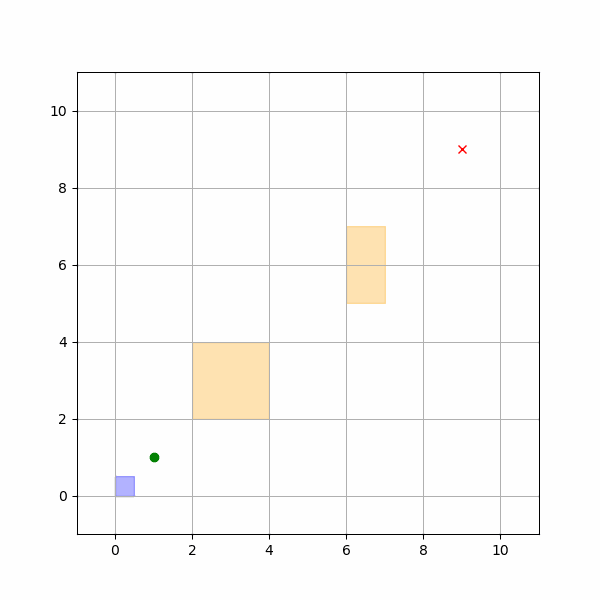

In [73]:
import math
import random
import matplotlib.pyplot as plt
from matplotlib import patches

# Use interactive backend for animation
%matplotlib inline

# Collision detection (Separating Axis Theorem for convex polygons)
def polygons_intersect(poly1, poly2):
    for polygon in (poly1, poly2):
        for i in range(len(polygon)):
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i + 1) % len(polygon)]
            axis = (-(y2 - y1), x2 - x1)
            proj1 = [axis[0]*x + axis[1]*y for x, y in poly1]
            proj2 = [axis[0]*x + axis[1]*y for x, y in poly2]
            if max(proj1) < min(proj2) or max(proj2) < min(proj1):
                return False
    return True

def is_collision_point(p, obstacles, robot):
    translated = [(x + p[0], y + p[1]) for x, y in robot]
    return any(polygons_intersect(translated, obs) for obs in obstacles)

def edge_collision(p1, p2, obstacles, robot, step=0.1):
    dist = math.hypot(p2[0]-p1[0], p2[1]-p1[1])
    steps = int(dist/step)
    for i in range(steps+1):
        t = i/steps
        xi = p1[0] + t*(p2[0]-p1[0])
        yi = p1[1] + t*(p2[1]-p1[1])
        if is_collision_point((xi, yi), obstacles, robot):
            return True
    return False

def euclidean(p1, p2):
    return math.hypot(p1[0]-p2[0], p1[1]-p2[1])

def rrt_generator(start, goal, obstacles, robot, bounds,
                  max_iter=500, step_size=0.5, goal_sample_rate=0.05):
    xmin, xmax, ymin, ymax = bounds
    nodes = [{'pos': start, 'parent': None}]
    yield nodes, None  # initial
    for _ in range(max_iter):
        sample = goal if random.random() < goal_sample_rate \
                 else (random.uniform(xmin, xmax), random.uniform(ymin, ymax))
        distances = [euclidean(n['pos'], sample) for n in nodes]
        idx = distances.index(min(distances))
        nearest = nodes[idx]['pos']
        theta = math.atan2(sample[1]-nearest[1], sample[0]-nearest[0])
        new_pos = (nearest[0] + step_size*math.cos(theta),
                   nearest[1] + step_size*math.sin(theta))
        if not edge_collision(nearest, new_pos, obstacles, robot):
            nodes.append({'pos': new_pos, 'parent': idx})
            yield nodes, len(nodes)-1
            if euclidean(new_pos, goal) < step_size:
                nodes.append({'pos': goal, 'parent': len(nodes)-1})
                yield nodes, len(nodes)-1
                break

robot     = [(0,0),(0.5,0),(0.5,0.5),(0,0.5)]
obstacles = [[(2,2),(4,2),(4,4),(2,4)], [(6,5),(7,5),(7,7),(6,7)]]
bounds    = (0,10,0,10)
start,goal = (1,1),(9,9)

# 3) Record every extension step
frames = list(rrt_generator(start, goal, obstacles, robot, bounds))

# 4) Create figure & static elements
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(bounds[0]-1, bounds[1]+1)
ax.set_ylim(bounds[2]-1, bounds[3]+1)
ax.set_aspect('equal'); ax.grid(True)
for obs in obstacles:
    ax.add_patch(patches.Polygon(obs, closed=True,
                  color='orange', alpha=0.3))
ax.plot(start[0], start[1], 'go')
ax.plot(goal[0],  goal[1],  'rx')

# 5) Add empty robot patch and list to collect lines
robot_patch = patches.Polygon(robot, closed=True,
                 color='blue', alpha=0.3)
ax.add_patch(robot_patch)
lines = []

# 6) Define the update function
def update(i):
    nodes, new_idx = frames[i]
    if new_idx is not None:
        child  = nodes[new_idx]
        parent = nodes[child['parent']]
        # draw the new edge
        line, = ax.plot(
            [parent['pos'][0], child['pos'][0]],
            [parent['pos'][1], child['pos'][1]],
            color='gray'
        )
        lines.append(line)
        # move robot to the new node
        x_off,y_off = child['pos']
        robot_patch.set_xy([(x+x_off, y+y_off) for x,y in robot])
    return lines + [robot_patch]

# 7) Build the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(frames),
    blit=True, interval=100
)

# 8) Save as GIF and display
ani.save('rrt_growth.gif', writer='pillow', fps=5)
plt.close(fig)   # close the static figure
Image(filename='rrt_growth.gif')

In [57]:
# Collision detection (Separating Axis Theorem for convex polygons)
def polygons_intersect(poly1, poly2):
    for polygon in (poly1, poly2):
        for i in range(len(polygon)):
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i + 1) % len(polygon)]
            axis = (-(y2 - y1), x2 - x1)
            proj1 = [axis[0]*x + axis[1]*y for x, y in poly1]
            proj2 = [axis[0]*x + axis[1]*y for x, y in poly2]
            if max(proj1) < min(proj2) or max(proj2) < min(proj1):
                return False
    return True

def is_collision_point(p, obstacles, robot):
    # Translate robot to point p and check for collision
    translated = [(x + p[0], y + p[1]) for x, y in robot]
    return any(polygons_intersect(translated, obs) for obs in obstacles)

def edge_collision(p1, p2, obstacles, robot, step=0.1):
    # Check along straight line from p1 to p2 for collision
    dist = math.hypot(p2[0]-p1[0], p2[1]-p1[1])
    steps = int(dist/step)
    for i in range(steps+1):
        t = i/steps
        xi = p1[0] + t*(p2[0]-p1[0])
        yi = p1[1] + t*(p2[1]-p1[1])
        if is_collision_point((xi, yi), obstacles, robot):
            return True
    return False

def euclidean(p1, p2):
    return math.hypot(p1[0]-p2[0], p1[1]-p2[1])

def rrt(start, goal, obstacles, robot, bounds, max_iter=500, step_size=0.5, goal_sample_rate=0.05):
    xmin, xmax, ymin, ymax = bounds
    nodes = [{'pos': start, 'parent': None}]
    for _ in range(max_iter):
        # sample
        if random.random() < goal_sample_rate:
            sample = goal
        else:
            sample = (random.uniform(xmin, xmax), random.uniform(ymin, ymax))
        # nearest
        distances = [euclidean(n['pos'], sample) for n in nodes]
        idx = distances.index(min(distances))
        nearest = nodes[idx]['pos']
        # steer
        theta = math.atan2(sample[1]-nearest[1], sample[0]-nearest[0])
        new_pos = (nearest[0] + step_size*math.cos(theta),
                   nearest[1] + step_size*math.sin(theta))
        # collision check along edge
        if not edge_collision(nearest, new_pos, obstacles, robot):
            nodes.append({'pos': new_pos, 'parent': idx})
            if euclidean(new_pos, goal) < step_size:
                nodes.append({'pos': goal, 'parent': len(nodes)-1})
                break
    return nodes

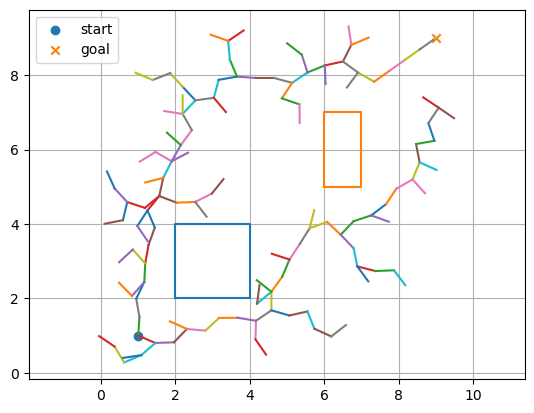

In [58]:
# Define robot and environment
robot = [(0,0), (0.5,0), (0.5,0.5), (0,0.5)]  # square robot
obstacle1 = [(2,2), (4,2), (4,4), (2,4)]
obstacle2 = [(6,5), (7,5), (7,7), (6,7)]
obstacles = [obstacle1, obstacle2]
bounds = (0, 10, 0, 10)
start = (1, 1)
goal = (9, 9)

# Run RRT
tree = rrt(start, goal, obstacles, robot, bounds,
           max_iter=1000, step_size=0.5, goal_sample_rate=0.1)

# Visualization
plt.figure()
# Plot obstacles
for obs in obstacles:
    xs = [p[0] for p in obs] + [obs[0][0]]
    ys = [p[1] for p in obs] + [obs[0][1]]
    plt.plot(xs, ys)

# Plot RRT tree edges
for node in tree:
    if node['parent'] is not None:
        x1, y1 = node['pos']
        x2, y2 = tree[node['parent']]['pos']
        plt.plot([x1, x2], [y1, y2])

# Plot start and goal
plt.scatter([start[0]], [start[1]], marker='o', label='start')
plt.scatter([goal[0]], [goal[1]], marker='x', label='goal')

plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# TODO: Implement RRT here

# TODO: Add your visualisation code to show the progression of the algorithm

### Coding Task 2.2 - An Alternative Sampling-based Algorithm
Implement the following sampling-based algorithm:
Initialize a tree $V$ with an initial, randomly sampled configuration $c_0$. Initialize a random goal configuration $c_\text{goal}$.
1. Select a random node from the tree, called $c_\text{random}$
2. Select a new random configuration, called $c_i$, from the collision-free configuration space
3. Extend from to $c_\text{random}$ to $c_i$, using the extend operation described above
4. Add the new nodes from the extend operation to the tree
5. If a goal configuration (within a certain, small delta) is added to the tree, terminate. Solution found!
6. Otherwise, go to step 1

Sketch a proof for why this algorithm is probabilistically complete or not. Give some reasoning whether this algorithm explores configuration space efficiently or not.

In [ ]:
# TODO: Implement this alternative sampling-based algorithm here

# TODO: Add your visualisation code to show the progression of the algorithm

*Sketch your proof here*

### Coding Task 2.3 - Exploiting Domain Knowledge
**Implement the following alternative algorithm:** instead of choosing a random node from the tree in line 1 of the algorithm given in Task 2.2, choose the node with the least heuristic value defined by:
$$
c_\text{random} = \text{argmin}_{x \in V} \text{straight-line-distance-to-goal}(x)
$$
where the `straight-line-distance-to-goal` function measures the straight-line distance to the goal from the given configuration x. Visualize its tree-growing procedure.

Answer the following questions: is RRT more efficient than the algorithms in Task 2.2 and Task 2.3? In which case could the algoritm in 2.3 be more efficient?

In [ ]:
# TODO: Implement this alternative algorithm with domain-knowledge here

# TODO: Add your visualisation code to show the progression of the algorithm

*Provide your answers to the questions here*

## Submission Checklist
- [ ] Implement all coding tasks
- [ ] Provide a proof sketch and answer the questions in Task 2.2
- [ ] Provide answers to the questions in Task 2.3